# Check MNE conversion steps against NIRS-Toolox

The nirs-toolbox can be found here...
https://bitbucket.org/huppertt/nirs-toolbox/wiki/Home

### Required python libraries

In [1]:
import mne
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
import os
import mne.externals.pymatreader


In [2]:
plt.rcParams["figure.figsize"] = (12,4)

## MATLAB
This is the exact code run to produce the MATLAB data

```matlab
addpath(genpath('nirs-toolbox'))
raw = nirs.io.loadNIRx('~/mne_data/MNE-testing-data/NIRx/nirx_15_2_recording', false);
raw.probe.link([1, 33], :) 
%     source    detector    type
%     ______    ________    ____
% 
%       1          1        760 
%       1          1        850 
data = raw.data(:, [1, 33]);
figure; plot(data)
save('raw_test.mat', 'data')


pipeline = nirs.modules.OpticalDensity();
OD_data = pipeline.run(raw);
OD_data.probe.link([1, 33], :) 
%     source    detector    type
%     ______    ________    ____
% 
%       1          1        760 
%       1          1        850  
data = OD_data.data(:, [1, 33]);
save('od_test.mat', 'data')


pipeline = nirs.modules.BeerLambertLaw();
BL_data = pipeline.run(OD_data);
BL_data.probe.link([1, 2, 3, 4], :) 
%     source    detector    type 
%     ______    ________    _____
% 
%       1           1       'hbo'
%       1           1       'hbr'
%       1          10       'hbo'
%       1          10       'hbr'   
data = BL_data.data(:, [1, 2, 3, 4]);
save('bl_test.mat', 'data')

```

## Test reading of raw data

In [3]:
matlab_data = mne.externals.pymatreader.read_mat('raw_test.mat')['data']
raw = mne.io.read_raw_nirx('/home/rluke/mne_data/MNE-testing-data/NIRx/nirx_15_2_recording', preload=True); 

Loading /home/rluke/mne_data/MNE-testing-data/NIRx/nirx_15_2_recording
Reading 0 ... 66  =      0.000 ...    16.896 secs...


(0.08, 0.13)

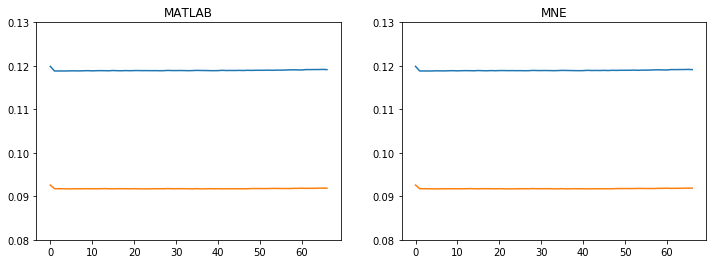

In [4]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(matlab_data[:,0], label='MATLAB')
axes[0].plot(matlab_data[:,1], label='MATLAB')
ax = axes[0]
ax.set_title('MATLAB')
ax.set_ylim(0.08, 0.13)


plt.plot(raw.get_data()[0], label=raw.info['chs'][0]['ch_name'], axes = axes[1])
plt.plot(raw.get_data()[1], label=raw.info['chs'][1]['ch_name'], axes = axes[1])
ax = axes[1]
ax.set_title('MNE')
ax.set_ylim(0.08, 0.13)

The data above look quite close.

Below we check they are exactly the same

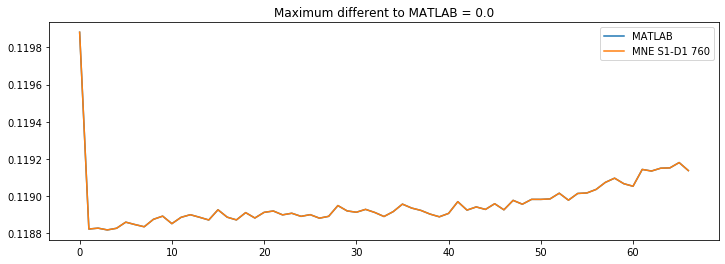

In [5]:
plt.plot(matlab_data[:,0], label='MATLAB')

plt.plot(raw.get_data()[0], label='MNE ' + raw.info['chs'][0]['ch_name'])
plt.title('Maximum different to MATLAB = ' + str(max(matlab_data[:,0] - raw.get_data()[0])))
plt.legend()

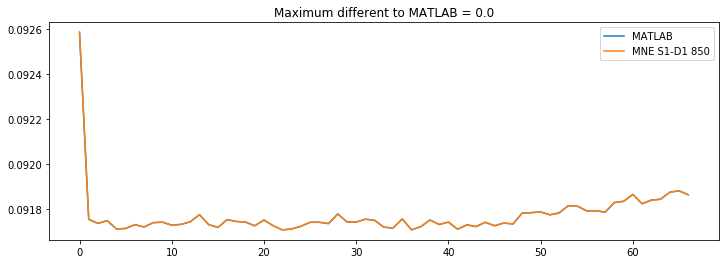

In [6]:
plt.plot(matlab_data[:,1], label='MATLAB')

plt.plot(raw.get_data()[1], label='MNE ' + raw.info['chs'][1]['ch_name'])
plt.title('Maximum different to MATLAB = ' + str(max(matlab_data[:,0] - raw.get_data()[0])))
plt.legend()

## Testing Optical Density

In [7]:
matlab_data = mne.externals.pymatreader.read_mat('od_test.mat')['data']
raw = mne.io.read_raw_nirx('/home/rluke/mne_data/MNE-testing-data/NIRx/nirx_15_2_recording', preload=True); 
raw = mne.preprocessing.optical_density(raw)

Loading /home/rluke/mne_data/MNE-testing-data/NIRx/nirx_15_2_recording
Reading 0 ... 66  =      0.000 ...    16.896 secs...


In [8]:
print(raw.info['chs'][0]['ch_name'])
print(raw.info['chs'][1]['ch_name'])

S1-D1 760
S1-D1 850


(-0.005, 0.002)

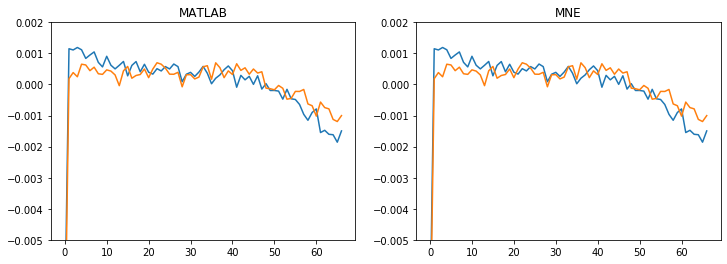

In [9]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(matlab_data[:,0], label='MATLAB')
axes[0].plot(matlab_data[:,1], label='MATLAB')
ax = axes[0]
ax.set_title('MATLAB')
ax.set_ylim(-0.005, 0.002)


plt.plot(raw.get_data()[0], label=raw.info['chs'][0]['ch_name'], axes = axes[1])
plt.plot(raw.get_data()[1], label=raw.info['chs'][1]['ch_name'], axes = axes[1])
ax = axes[1]
ax.set_title('MNE')
ax.set_ylim(-0.005, 0.002)

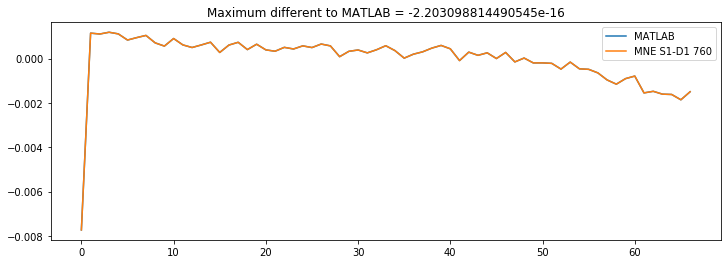

In [10]:
plt.plot(matlab_data[:,0], label='MATLAB')

plt.plot(raw.get_data()[0], label='MNE ' + raw.info['chs'][0]['ch_name'])
plt.title('Maximum different to MATLAB = ' + str(max(matlab_data[:,0] - raw.get_data()[0])))
plt.legend()

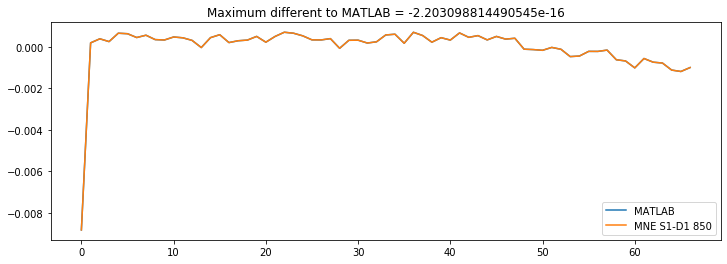

In [11]:
plt.plot(matlab_data[:,1], label='MATLAB')

plt.plot(raw.get_data()[1], label='MNE ' + raw.info['chs'][1]['ch_name'])
plt.title('Maximum different to MATLAB = ' + str(max(matlab_data[:,0] - raw.get_data()[0])))
plt.legend()

## Testing Beer Lambert Conversion

In [12]:
matlab_data = mne.externals.pymatreader.read_mat('bl_test.mat')['data']
raw = mne.io.read_raw_nirx('/home/rluke/mne_data/MNE-testing-data/NIRx/nirx_15_2_recording', preload=True); 
raw = mne.preprocessing.optical_density(raw)
raw = mne.preprocessing.beer_lambert_law(raw)

Loading /home/rluke/mne_data/MNE-testing-data/NIRx/nirx_15_2_recording
Reading 0 ... 66  =      0.000 ...    16.896 secs...


### MATLAB stores data in uM, MNE stores data in M. So scaling of MNE is required for comparison

In [13]:
raw._data *= 1e6

In [14]:
# First data point is a large outlier, tidy up
raw.crop(tmin = 0.2)
matlab_data = matlab_data[1:, :]

No handles with labels found to put in legend.


(-2.0, 2.0)

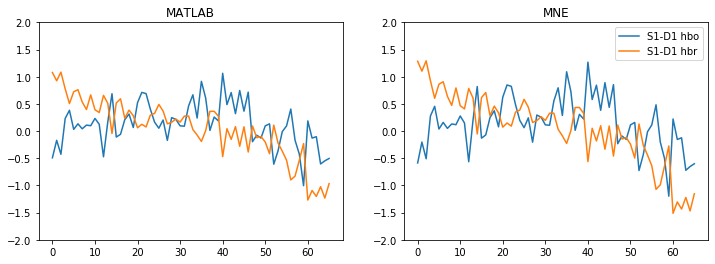

In [15]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(matlab_data[:,0], label='MATLAB')
axes[0].plot(matlab_data[:,1], label='MATLAB')
ax = axes[0]
ax.set_title('MATLAB')
plt.legend()
ax.set_ylim(-2.0, 2.0)

plt.plot(raw.get_data()[0], label=raw.info['chs'][0]['ch_name'], axes = axes[1])
plt.plot(raw.get_data()[1], label=raw.info['chs'][1]['ch_name'], axes = axes[1])
ax = axes[1]
ax.set_title('MNE')
plt.legend()
ax.set_ylim(-2.0, 2.0)

And try a few more channels

No handles with labels found to put in legend.


(-2.0, 2.0)

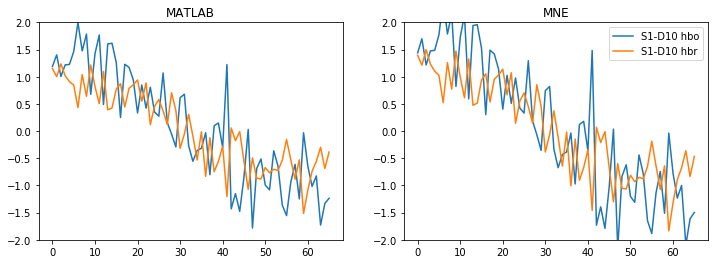

In [16]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(matlab_data[:,2], label='MATLAB')
axes[0].plot(matlab_data[:,3], label='MATLAB')
ax = axes[0]
ax.set_title('MATLAB')
plt.legend()
ax.set_ylim(-2.0, 2.0)

plt.plot(raw.get_data()[2], label=raw.info['chs'][2]['ch_name'], axes = axes[1])
plt.plot(raw.get_data()[3], label=raw.info['chs'][3]['ch_name'], axes = axes[1])
ax = axes[1]
ax.set_title('MNE')
plt.legend()
ax.set_ylim(-2.0, 2.0)

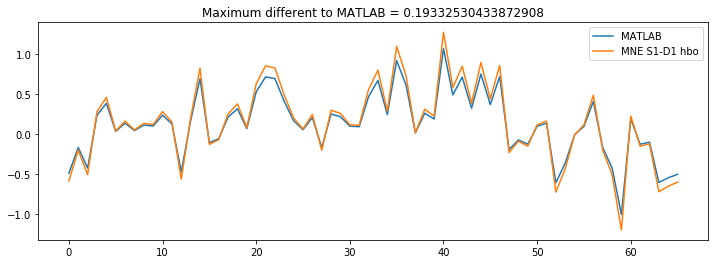

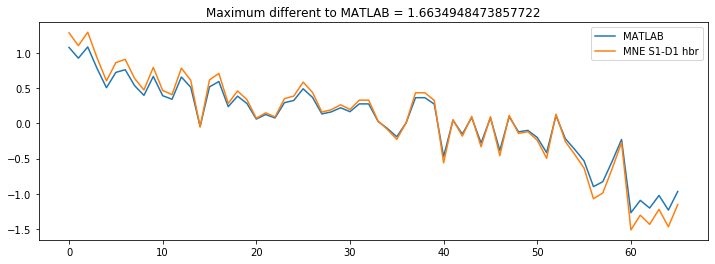

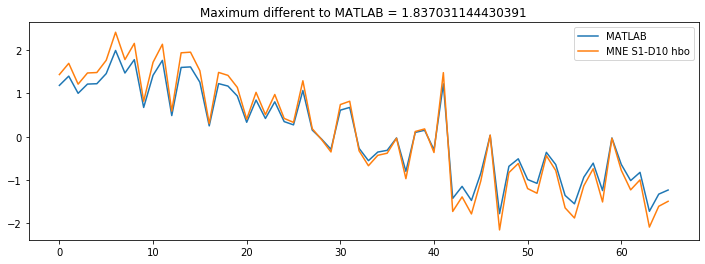

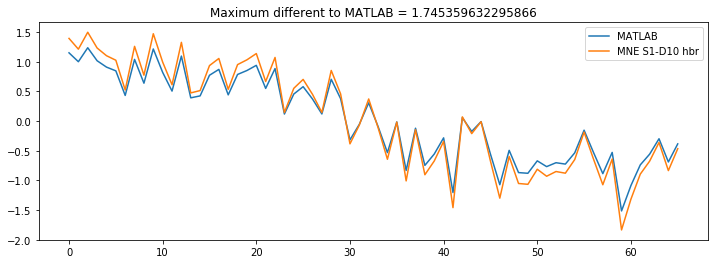

In [17]:
for data_channel in range(4):

    plt.plot(matlab_data[:,data_channel], label='MATLAB')

    plt.plot(raw.get_data()[data_channel], label='MNE ' + raw.info['chs'][data_channel]['ch_name'])
    plt.title('Maximum different to MATLAB = ' + str(max(matlab_data[:,data_channel] - raw.get_data()[0])))
    plt.legend()
    plt.show()

So there are some slight differences between MATLAB and MNE here:

* Slight scaling difference
* Pattern is always the same
* Scaling is always away from 0

So this is likely due to:
* Slight differences in distance calculation between sources and detectors
* NIRS toolbox has an extra decimal point of accuracy in their extinction coefficients